# Sentiment analysis of a corpus of Tweets to positive and negative

In [2]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import string
import re
import nltk
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, twitter_samples, wordnet 
from nltk.stem import WordNetLemmatizer , PorterStemmer


In [6]:

nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/mpir0002/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mpir0002/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mpir0002/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/mpir0002/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<a name="1"></a>
## 1) Load and tokenizing data


In [3]:

lemmatizer = WordNetLemmatizer()
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()
print(stopwords_english[0:20])


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [4]:

def load_tweets():
    all_positive_tweets = twitter_samples.strings('positive_tweets.json')
    all_negative_tweets = twitter_samples.strings('negative_tweets.json')  
    return all_positive_tweets, all_negative_tweets


In [5]:
# Function to convert NLTK POS tags to WordNet POS tags
def pos_tag_convert(nltk_tag: str) -> str:
    '''Converts nltk tags to tags that are understandable by the lemmatizer.
    
    Args:
        nltk_tag (str): nltk tag
        
    Returns:
        _ (str): converted tag
    '''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN


In [6]:

def process_tweet(sentence):
    '''
    Input: 
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    
    '''
    # remove stock market tickers like $GE
    sentence = re.sub(r'\$\w*', '', sentence)
    # remove old style retweet text "RT"
    sentence = re.sub(r'^RT[\s]+', '', sentence)
    # remove hyperlinks
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence)
    # remove hashtags
    # only removing the hash # sign from the word
    sentence = re.sub(r'#', '', sentence)
    # tokenize tweets
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    # preserve_case=False: Converts text to lowercase.
    # strip_handles=True: Removes Twitter handles (e.g., @user).
    # reduce_len=True: Reduces elongated words (e.g., loooove -> looove).
    tokens = nltk.pos_tag(tokenizer.tokenize(sentence))
    
    tokens_clean = []
    for token in tokens:
        word = token[0]
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            #word = stemmer.stem(word)
            stem_word = lemmatizer.lemmatize(word , pos_tag_convert(token[1]))
            tokens_clean.append(stem_word)
    return tokens_clean


In [7]:
sentence = "I loooove NLP!!! It's amazing."
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tokens = nltk.pos_tag(tokenizer.tokenize(sentence))
print(tokens)
print(tokens[1][0])


[('i', 'NN'), ('looove', 'VBP'), ('nlp', 'NN'), ('!', '.'), ('!', '.'), ('!', '.'), ("it's", 'JJ'), ('amazing', 'NN'), ('.', '.')]
looove


In [8]:

# The difference between `lemmatizer.lemmatize(word, pos_tag_convert(token[1]))` and `lemmatizer.lemmatize(word)` lies in the usage of the part-of-speech (POS) tag to guide the lemmatization process.

# ### Without POS Tag

# ```python
# lemmatizer.lemmatize(word)
# ```

# When you use the `lemmatizer.lemmatize(word)` method without providing a POS tag, the default POS tag used is `noun`. This means the lemmatizer will assume that the word is a noun, and it will return the base form (lemma) of the word as if it were a noun.

# ### With POS Tag

# ```python
# lemmatizer.lemmatize(word, pos_tag_convert(token[1]))
# ```

# When you provide a POS tag using `lemmatizer.lemmatize(word, pos_tag_convert(token[1]))`, the lemmatizer uses the provided POS tag to determine the correct base form of the word. This leads to more accurate lemmatization because different POS tags can have different lemmas.

# ### Example

# Consider the word "running" and its different lemmas depending on the POS tag:

# 1. **Without POS Tag (Assumes Noun):**

# ```python
# lemmatizer.lemmatize('running')
# ```

# Output:
# ```
# 'running'  # Assumes 'running' is a noun and returns it as is.
# ```

# 2. **With POS Tag (Verb):**

# ```python
# lemmatizer.lemmatize('running', wordnet.VERB)
# ```

# Output:
# ```
# 'run'  # Correctly identifies 'running' as a verb and returns 'run'.
# ```

# ### Full Example

# Here's a complete example showing both cases:

# ```python
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# # Download necessary NLTK data files
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# # Initialize lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Function to convert NLTK POS tags to WordNet POS tags
# def pos_tag_convert(nltk_tag: str) -> str:
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN


In [9]:
# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [10]:

tweet_number = 2
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])


Positive tweet example:
@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!

Negative tweet example:
@Hegelbon That heart sliding into the waste basket. :(


In [11]:

# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]


In [12]:

tweet_number = 2
print('Positive processed tweet example:')
print(all_positive_tweets_processed[tweet_number])
print('\nNegative processed tweet example:')
print(all_negative_tweets_processed[tweet_number])


Positive processed tweet example:
['listen', 'last', 'night', ':)', 'bleed', 'amazing', 'track', 'scotland']

Negative processed tweet example:
['heart', 'slide', 'waste', 'basket', ':(']


<a name="1"></a>
## 2) Splitting  data into train and test


In [13]:

train_pos = all_positive_tweets_processed[:4000]
test_pos = all_positive_tweets_processed[4000:]

train_neg = all_negative_tweets_processed[:4000]
test_neg = all_negative_tweets_processed[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
test_y = [[1] for _ in test_pos] + [[0] for _ in test_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(test_x)} sentences for validation.")
print(f"There are {len(test_y)} labels for validation.")


There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


<a name="1"></a>
## 3) Build the vocabulary


In [14]:

def build_vocabulary(corpus):
    
    '''Function that builds a vocabulary from the given corpus
    Input: 
        - corpus (list): the corpus
    Output:
        - vocab (dict): Dictionary of all the words in the corpus.
                The keys are the words and the values are integers.
    '''

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1} 

    
    # For each tweet in the training set
    for tweet in corpus:
        # For each word in the tweet
        for word in tweet:
            # If the word is not in vocabulary yet, add it to vocabulary
            if word not in vocab:
                vocab[word] = len(vocab)
    
    return vocab


In [15]:

vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
list(vocab.items())[0:10]


Vocabulary contains 9535 words



[('', 0),
 ('[UNK]', 1),
 ('followfriday', 2),
 ('top', 3),
 ('engage', 4),
 ('member', 5),
 ('community', 6),
 ('week', 7),
 (':)', 8),
 ('hey', 9)]

<a name="1"></a>
## 4) Convert a Tweet to a Tensor

You have to look at all tweets in the training and validation set and find the longest one to pad all of them to the maximum length.

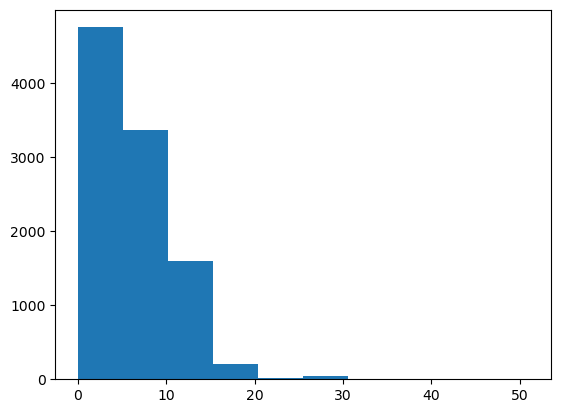

In [17]:
plt.hist([len(t) for t in train_x + test_x]);

In [18]:
list(vocab.items())[:6]

[('', 0),
 ('[UNK]', 1),
 ('followfriday', 2),
 ('top', 3),
 ('engage', 4),
 ('member', 5)]

In [19]:
list(vocab.items())[-6:]

[('bun', 9529),
 ('dislike', 9530),
 ('burdensome', 9531),
 ('amelia', 9532),
 ('melon', 9533),
 ('soccer', 9534)]

In [21]:

def max_length(training_x, validation_x):
    
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """
    
    combined_x = training_x + validation_x
    max_len = max(len(tweet) for tweet in combined_x)
    
    return max_len

max_len = max_length(train_x, test_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [22]:

def padded_sequence(tweet, vocab_dict, max_len, unk_token = '[UNK]'):
    
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """
    
    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict.get(unk_token, 1)
    
    # First convert the words to integers by looking up the vocab_dict
    encoded_tweet = [vocab_dict.get(word, unk_ID) for word in tweet]

    # Then pad the tensor with zeroes up to the length max_len
    padded_tensor = encoded_tweet + [0] * (max_len - len(encoded_tweet))


    return padded_tensor

In [24]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
test_x_padded = [padded_sequence(x, vocab, max_len) for x in test_x]

In [28]:
print(train_x[10])
print(train_x_padded[10])

['followfriday', 'top', 'influencers', 'community', 'week', ':)']
[2, 3, 89, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<a name="1"></a>
## 5) Text classifier: fully connected dense layer

Model initializes the embedding layer by random numbers

<a name="1"></a>
**Input Shape:**              
The input to this layer should be a 3D tensor with shape (batch_size, timesteps, features).          
batch_size: Number of samples in the batch.          
timesteps: Number of time steps in each sample.           
features: Number of features per time step.          

In [35]:

def create_model(num_words, embedding_dim, max_len):
    """
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(), # Captures Overall Sentiment
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 51, 16)            152560    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 152,577
Trainable params: 152,577
Non-trainable params: 0
_________________________________________________________________


<a name="1"></a>
### Training the model

In [38]:

train_x_prepared = np.array(train_x_padded)
test_x_prepared = np.array(test_x_padded)

train_y_prepared = np.array(train_y)
test_y_prepared = np.array(test_y)

history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(test_x_prepared, test_y_prepared))

Epoch 1/20
250/250 [==============================] - 2s 3ms/step - loss: 0.6829 - accuracy: 0.6625 - val_loss: 0.6664 - val_accuracy: 0.9870
Epoch 2/20
250/250 [==============================] - 1s 2ms/step - loss: 0.6312 - accuracy: 0.9516 - val_loss: 0.5955 - val_accuracy: 0.9765
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.5378 - accuracy: 0.9875 - val_loss: 0.4964 - val_accuracy: 0.9885
Epoch 4/20
250/250 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.9902 - val_loss: 0.3952 - val_accuracy: 0.9930
Epoch 5/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3333 - accuracy: 0.9942 - val_loss: 0.3089 - val_accuracy: 0.9920
Epoch 6/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2551 - accuracy: 0.9944 - val_loss: 0.2418 - val_accuracy: 0.9955
Epoch 7/20
250/250 [==============================] - 1s 2ms/step - loss: 0.1960 - accuracy: 0.9954 - val_loss: 0.1895 - val_accuracy: 0.9945
Epoch 

<a name="1"></a>
### Evaluate the model

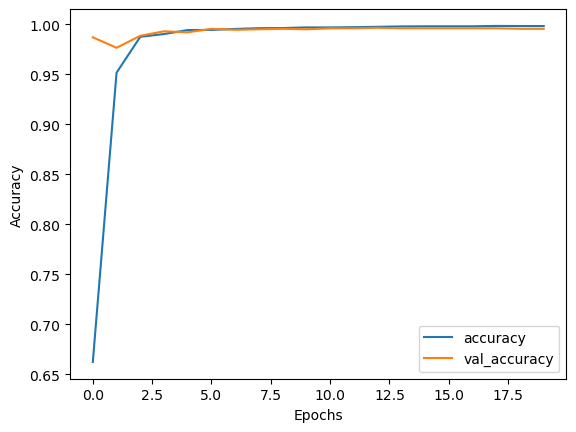

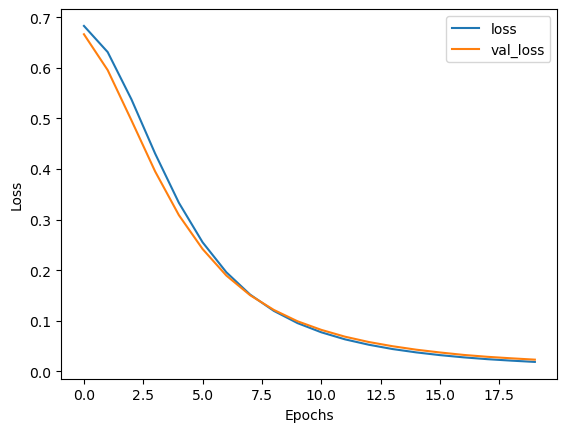

In [40]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

<a name="1"></a>
### Prediction

In [42]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)
    
    return prediction[0][0]

In [46]:
new_tweet = '@Mehran @ML team OMG!!! What the hell, These people are cruel!!!'

prediction = get_prediction_from_tweet(new_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction}")

Model prediction on unseen tweet: 0.3944305181503296


<a name="1"></a>
## 6) Text classifier: Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [87]:
train_x_prepared.shape

(8000, 51)

In [88]:
train_x_prepared

array([[   2,    3,    4, ...,    0,    0,    0],
       [   9,   10,   11, ...,    0,    0,    0],
       [  22,   23,   24, ...,    0,    0,    0],
       ...,
       [ 361,  305,  984, ...,    0,    0,    0],
       [ 133, 1616,  221, ...,    0,    0,    0],
       [  36, 1320,  116, ...,    0,    0,    0]])

In [51]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_x_prepared, train_y_prepared)

/home/mpir0002/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [78]:
# Test with a new tweet with Naive Bayes
new_tweet = "What the heck is going on!" # It doesn't look a positive tweet but the model classifies that as positive
new_tweet = process_tweet(new_tweet)
new_tweet = padded_sequence(new_tweet, vocab, max_len)
new_tweet = np.array([new_tweet])
new_prediction = nb_classifier.predict(new_tweet)
print(new_prediction)

[1]


In [84]:
# Test with a new tweet with neural network model
pred = prediction = model.predict(new_tweet, verbose=False)
print(pred)
print([1 if pred > 0.5 else 0])

[[0.46918467]]
[0]


<a name="1"></a>
## 7) Accuracy for the two models

In [90]:
# Neural network model
labels_pred_deep = model.predict(test_x_prepared, verbose=False)
labels_pred_deep = [1 if pred > 0.5 else 0 for pred in labels_pred_deep]
print("Accuracy:", accuracy_score(test_y_prepared, labels_pred_deep))


Accuracy: 0.9955


In [85]:
# Naive Bayes classifier
labels_pred_nb = nb_classifier.predict(test_x_prepared)
print("Accuracy:", accuracy_score(test_y_prepared, labels_pred_nb))
#print("Classification Report:\n", classification_report(test_y_prepared, labels_pred_nb))


Accuracy: 0.5205


## 8) Conclusion    
Neural network works better than Naive Bayes. Unlike deep learning models that start learning an embedding layer for each token to perform prediction, Naive Bayes counts the number of occurrences of each word in a document (Bag-of-Words), then Measures the importance of a word in a document relative to a corpus (TF-IDF).